In [ ]:
%load_ext autoreload
%autoreload 2
import dynamics
import c_dynamics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import main
import h5py
from scipy import optimize, signal

plt.style.use("plot_style.mplstyle")

def calcTheta(vec):
    return np.arctan2(vec[1], vec[0])

def calcPhi(vec):
    return np.arccos(vec[2])

In [ ]:
# NOTE: very interesting point at beta=0.1, vol=4.5e-10, omega0=[0,+2,-1]
a_perp, a_para=dynamics.spheriodDimensionsFromBeta(beta=0.1, particle_volume=4.5e-10)
const = dynamics.SystemConstants(
    a_perp=a_perp,
    a_para=a_para,
)
rng = np.random.default_rng(0)

x0     = np.array([0,0,0])
v0     = np.array([const.v_g, 0, 0]) + 1e-6 * const.W * rng.normal(size=3)
n0     = np.array([1,0,0])
omega0 = np.array([0, 0, 1e-7]) #  0.9922778997e-3
y0 = np.concat([x0, v0, n0, omega0])

t_span=(0.0, 105.0)
t = np.concat([
    [0.0],
    np.linspace(*t_span, num=100_000),
])

t, res = c_dynamics.solveDynamics(
    y0=y0,
    const=const,
    t_eval=t,
    t_span=t_span,
    rel_tol=1e-6,
    abs_tol=1e-6,
    event_type=0
)
omega = np.sum(res[1:,10:12], axis=1)
print((np.max(omega) + np.min(omega)) / 2)

In [ ]:
plt.figure()
plt.plot(t[1::5], (res[1::5,10]), label="$\\omega_y$", color="gray")
plt.plot(t[1::5], (res[1::5,11]), label="$\\omega_z$", color="cornflowerblue")
plt.plot(t[1::5], (res[1::5,9]), label="$\\omega_x$", color="orange")
plt.legend()
plt.xlim(0, 105)
plt.xlabel("Time $t\\,/\\,\\tau_p$ (1)")
plt.ylabel("Angular velocity $\\omega\\,/\\,\\tau_p$ (1)")
plt.savefig("figures/overall_trajectory_limit_cycle.pdf", bbox_inches="tight")

plt.figure()
idx = (t>41.9) & (t<42.1)
plt.plot(t[idx][::5], (res[:,9])[idx][::5], label="$\\omega_x$", color="orange")
plt.plot(t[idx][::5], (res[:,10])[idx][::5], label="$\\omega_y$", color="gray")
plt.plot(t[idx][::5], (res[:,11])[idx][::5], label="$\\omega_z$", color="cornflowerblue")
plt.legend()
plt.xlim(41.9, 42.1)
plt.xlabel("Time $t\\,/\\,\\tau_p$ (1)")
plt.ylabel("Angular velocity $\\omega\\,/\\,\\tau_p$ (1)")
plt.savefig("figures/transition_trajectory_limit_cycle.pdf", bbox_inches="tight")

plt.figure()
omega = res[:,9]# np.sum(res[:,10:12], axis=1)
f, Pxx = signal.periodogram(omega[1:], fs=1 / (t[2]- t[1]))
plt.plot(f[1:], Pxx[1:], label="PSD($\\omega_{x})$", color="orange")
omega = res[:,10]# np.sum(res[:,10:12], axis=1)
f, Pxx = signal.periodogram(omega[1:], fs=1 / (t[2]- t[1]))
plt.plot(f[1:], Pxx[1:], label="PSD($\\omega_{y})$", color="gray")
omega = res[:,11]# np.sum(res[:,10:12], axis=1)
f, Pxx = signal.periodogram(omega[1:], fs=1 / (t[2]- t[1]))
plt.plot(f[1:], Pxx[1:], label="PSD($\\omega_{z})$", color="cornflowerblue")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e0, f[-1])
plt.xlabel("Frequency $f\\,/\\,\\tau_p$ (1)")
plt.ylabel("PSD (1)")
plt.legend()
plt.savefig("figures/psd_limit_cycle.pdf", bbox_inches="tight")
plt.show()

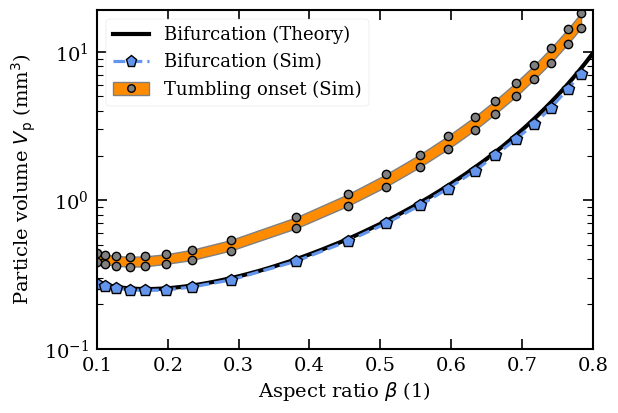

In [45]:
with h5py.File("data/bifurcation_search_002.h5") as f:
    sim_bif_beta = f['betas'][:]
    sim_bif_vols = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_bif_beta))])
with h5py.File("data/tumbling_transition_high_search_001.h5") as f:
    sim_tum_low_beta = f['betas'][:]
    sim_tum_low_vols = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_tum_low_beta))])
with h5py.File("data/tumbling_transition_low_search_001.h5") as f:
    sim_tum_high_beta = f['betas'][:]
    sim_tum_high_vols = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_tum_high_beta))])
beta, volume = np.loadtxt("data/bifurcation_high.txt", delimiter=";")

plt.style.use("plot_style.mplstyle")
plt.figure()
b_theo = plt.plot(beta, volume * 1e9, ls="solid", color="black",  lw=3,)[-1]
b_sim = plt.plot(
    sim_bif_beta, sim_bif_vols * 1e9, ls="--", color="cornflowerblue",
    marker="p", markersize=9, markeredgecolor="black", markeredgewidth=1,
)[-1]
t_fill = plt.fill_between(
    sim_tum_low_beta, y1=sim_tum_low_vols * 1e9, y2=sim_tum_high_vols * 1e9,
    color="darkorange", edgecolor="gray", lw=1,
)
t_point = plt.plot(
    np.concat([sim_tum_low_beta, sim_tum_high_beta]),
    np.concat([sim_tum_low_vols, sim_tum_high_vols]) * 1e9,
    color="gray", ls="",
    marker="o", markersize=6, markeredgecolor="black", markeredgewidth=1,
)[-1]
plt.xlim(0.1, 0.8)
plt.ylim(bottom=1e-1)
plt.yscale("log")
plt.xlabel("Aspect ratio $\\beta$ (1)")
plt.ylabel("Particle volume $V_\\text{p}$ (mm$^3$)")
plt.legend([b_theo, b_sim, (t_fill, t_point)],
            ["Bifurcation (Theory)", "Bifurcation (Sim)", "Tumbling onset (Sim)"],
            loc="upper left", markerscale=0.9,
            handler_map={tuple: matplotlib.legend_handler.HandlerTuple()})

plt.savefig("figures/bifurcation_diagram.pdf", bbox_inches="tight")
def galileoNumber(particle_volume):
    g = 9.81
    nu = 1.51147e-5
    curly_R = 1.2e3 / 1.204
    curly_V = g * particle_volume / nu ** 2
    return np.sqrt((6 / np.pi) * curly_R * curly_V)

def willmarthInertiaParameter(beta):
    curly_R = 1.2e3 / 1.204
    return (5 * np.sqrt(3) / 256) * beta * curly_R

# plt.figure()
# plt.plot(galileoNumber(volume), willmarthInertiaParameter(beta))
# plt.plot(galileoNumber(sim_vols), willmarthInertiaParameter(sim_beta))
# plt.plot(galileoNumber(sim_tumble_vols), willmarthInertiaParameter(sim_tumble_beta))
# plt.show()

In [46]:
def thetaVsOmegaP(ax: plt.Axes, theta, omega_p, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, omega_p[limit_cycle], label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Angular velocity $\\omega_\\text{p}\\,\\tau_\\text{p}$ (1)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def thetaVsOmegaS(ax: plt.Axes, theta, omega_s, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, omega_s[limit_cycle], label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Angular velocity $\\omega_\\text{s}\\,\\tau_\\text{p}$ (1)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def thetaVsVelG(ax: plt.Axes, theta, vel_g, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, vel_g[limit_cycle], label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Velocity $v_\\text{G}\\,/(g\\,\\tau_\\text{p})$ (1)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def thetaVsVelP(ax: plt.Axes, theta, vel_p, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, vel_p[limit_cycle], label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Velocity $v_\\text{P}\\,/(g\\,\\tau_\\text{p})$ (1)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def thetaVsVelS(ax: plt.Axes, theta, vel_s, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, vel_s[limit_cycle], label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Velocity $v_\\text{S}\\,/(g\\,\\tau_\\text{p})$ (1)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def thetaVsPhi(ax: plt.Axes, theta, phi, volume: float, limit_cycle: slice):
    ax.plot(theta[limit_cycle] * 180 / np.pi, phi[limit_cycle] * 180 / np.pi, label=f"${volume * 1e9:.4f}\\,$mm$^3$")
    ax.set(
        xlabel = "Angle $\\theta$ (deg)",
        ylabel = "Angle $\\varphi$ (deg)",
    )
    ax.legend(title="Limit cycles ($V_\\text{p}$)", labelspacing=0.4)

def inferLimitCycle(arr):
    peak_idx, _ = signal.find_peaks(arr)
    limit_cycle = slice(peak_idx[-3], peak_idx[-1])
    return limit_cycle

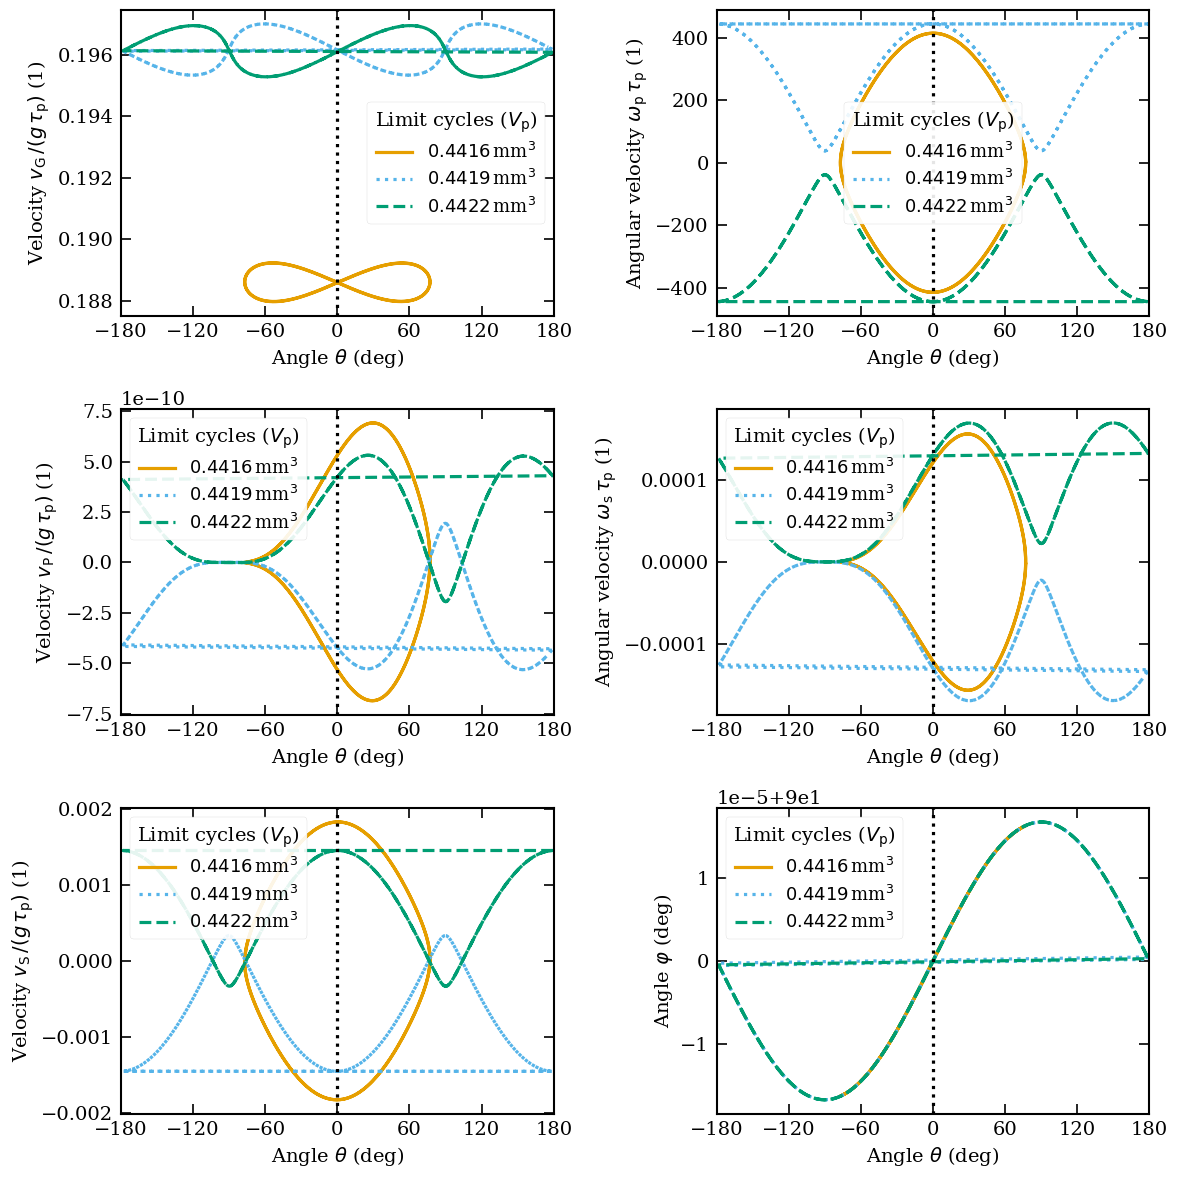

In [47]:
n_points = 10_000
with h5py.File("data/tumbling_transition_low_search_001.h5") as f:
    # sim_tum_high_beta = f['betas'][:]
    state_arr = np.squeeze([f[f"{i}/state"][:] for i in range(1)])
    volume_arr = np.squeeze([f[f"{i}/volume"][:] for i in range(1)])

fig, axes = plt.subplots(3,2, figsize=(12, 12))
for sim_idx in [-5, -1, -2]:
    state = state_arr[sim_idx,-n_points:]
    v = volume_arr[sim_idx]
    n_cart = state[:,3:6].T
    n_cart = n_cart / np.linalg.norm(n_cart, axis=0)
    nx, ny, nz = n_cart
    phi = calcPhi(n_cart)
    theta = calcTheta(n_cart)
    vel = state[:,:3].T
    omega = state[:,6:9].T
    wx, wy, wz = omega

    # GPS coordinate system
    g = np.array([1,0,0])
    p = np.vstack([np.zeros_like(phi), np.cos(phi), np.sin(phi)])
    s = np.vstack([np.zeros_like(phi),-np.sin(phi), np.cos(phi)])

    vel_g = np.sum(vel * g[:,None], axis=0)
    vel_p = np.sum(vel * p, axis=0)
    vel_s = np.sum(vel * s, axis=0)

    omega_g = np.sum(omega * g[:,None], axis=0)
    omega_p = np.sum(omega * p, axis=0)
    omega_s = np.sum(omega * s, axis=0)
    # print(state[-1, :3])
    # print(np.mean([
    #     np.sum(state[:, :3] * g, axis=1),
    #     np.sum(state[:, :3] * p[:,-1], axis=1),
    #     np.sum(state[:, :3] * s[:,-1], axis=1)
    # ], axis=1))
    # select best estimate of limit cycle
    thetaVsOmegaP(axes[0,1], theta, omega_p, v, inferLimitCycle(theta))
    thetaVsOmegaS(axes[1,1], theta, omega_s, v, inferLimitCycle(theta))
    thetaVsVelG(axes[0,0], theta, vel_g, v, inferLimitCycle(theta))
    thetaVsVelP(axes[1,0], theta, vel_p, v, inferLimitCycle(theta))
    thetaVsVelS(axes[2,0], theta, vel_s, v, inferLimitCycle(theta))
    thetaVsPhi(axes[2,1], theta, phi, v, inferLimitCycle(theta))
for ax in axes.flatten():
    ax.axvline(0, color="black", ls=":")
    ax.set(
        xlim = (-180, 180),
        xticks = np.linspace(-180, 180, 7),
    )
plt.tight_layout()
plt.show()



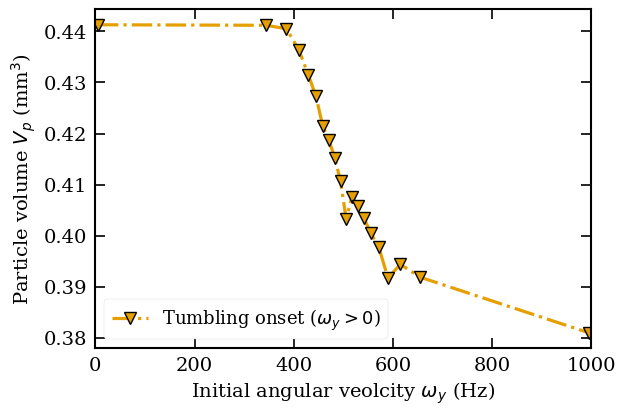

In [49]:
with h5py.File("data/omega_z_search_001.h5") as f:
    sim_omega_z = f['omegas'][:,2]
    sim_vols_z = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega_z))])

with h5py.File("data/omega_y_search_004.h5") as f:
    sim_omega_y = f['omegas'][:,1]
    sim_vols_y = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega_y))])
plt.figure()
# plt.plot(sim_omega_z, sim_vols_z * 1e9, ls="--", marker="o",
#     markeredgewidth=1, markeredgecolor="black", markersize=10, label="$\\omega_z>0$")
plt.plot(sim_omega_y, sim_vols_y * 1e9, ls="-.", marker="v",
    markeredgewidth=1, markeredgecolor="black", markersize=8, label="Tumbling onset ($\\omega_y>0$)")
plt.xlabel("Initial angular veolcity $\\omega_y$ (Hz)")
plt.ylabel("Particle volume $V_p$ (mm$^3$)")
plt.xlim(0,1000)
plt.legend()
plt.savefig("figures/tumbling_onset-volume-vs-angular_velocity.pdf", bbox_inches="tight")
plt.show()

[ 5.58769753e-11 -1.86118153e-02  5.00253004e+02  3.85515358e-10]


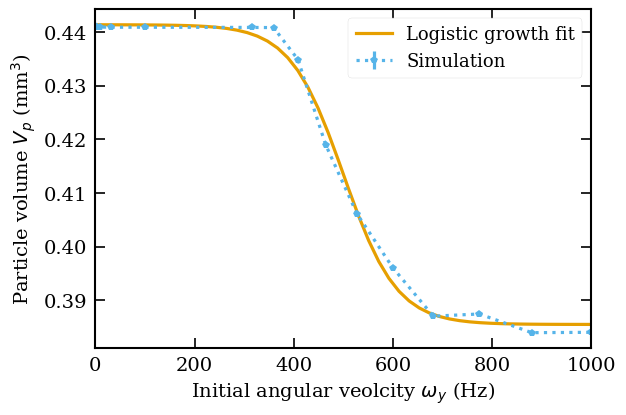

In [50]:
with h5py.File("data/omega_y_search_001.h5") as f:
    sim_omega = f['omegas'][:,1]
    sim_vols = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega))])

with h5py.File("data/omega_y_search_002.h5") as f:
    sim_omega_fine = f['omegas'][:,1]
    sim_vols_fine = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega_fine))])
# combine runs
sim_omega = np.concat([sim_omega, sim_omega_fine])
idx = np.argsort(sim_omega)
sim_omega = sim_omega[idx]
sim_vols = np.concat([sim_vols, sim_vols_fine])[idx]

# fit model
def logisticGrowth(x, C, gamma, x0, b):
    return C / (1 + np.exp(-gamma * (x - x0))) + b
popt, pcov = optimize.curve_fit(logisticGrowth, sim_omega, sim_vols, p0=[np.max(sim_vols) - np.min(sim_vols), -1e-2, 500, np.min(sim_vols)])
print(popt)
plt.figure()
plt.plot(np.linspace(0, 1000), logisticGrowth(np.linspace(0,1000), *popt) * 1e9, label="Logistic growth fit")
plt.errorbar(sim_omega, sim_vols * 1e9, yerr=3.417968750001291e-14 * 1e9/ 2, marker="p", label="Simulation")
plt.xlabel("Initial angular veolcity $\\omega_y$ (Hz)")
plt.ylabel("Particle volume $V_p$ (mm$^3$)")
plt.legend()
plt.xlim(0, 1000)
plt.show()

In [51]:
with h5py.File("omega_z_search_001.h5") as f:
    sim_omega = f['omegas'][:,2]
    sim_vols = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega))])

# with h5py.File("omega_y_search_002.h5") as f:
#     sim_omega_fine = f['omegas'][:,1]
#     sim_vols_fine = np.array([f[f"{i}/volume"][-1] for i in range(len(sim_omega_fine))])

# combine runs
# sim_omega = np.concat([sim_omega, sim_omega_fine])
# idx = np.argsort(sim_omega)
# sim_omega = sim_omega[idx]
# sim_vols = np.concat([sim_vols, sim_vols_fine])[idx]

# fit model
def logisticGrowth(x, C, gamma, x0, b):
    return C / (1 + np.exp(-gamma * (x - x0))) + b
popt, pcov = optimize.curve_fit(logisticGrowth, sim_omega, sim_vols, p0=[np.max(sim_vols) - np.min(sim_vols), -1e-2, 500, np.min(sim_vols)])
print(popt)
plt.plot(np.linspace(0, 1000), logisticGrowth(np.linspace(0,1000), *popt) * 1e9)
plt.errorbar(sim_omega, sim_vols * 1e9, yerr=3.417968750001291e-14 * 1e9/ 2, marker="p")
# plt.plot()
plt.xlabel("Initial angular veolcity $\\omega_y$ (Hz)")
plt.ylabel("Particle volume $V_p$ (mm$^3$)")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'omega_z_search_001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print(popt[1], popt[2])

In [ ]:
p = np.linspace(1e-4, 1-1e-4, 20)
print(np.log(p/(1-p)) / popt[1] + popt[2])
plt.plot(np.log(p/(1-p)) / popt[1] + popt[2], popt[0] * p + popt[-1], marker="o")


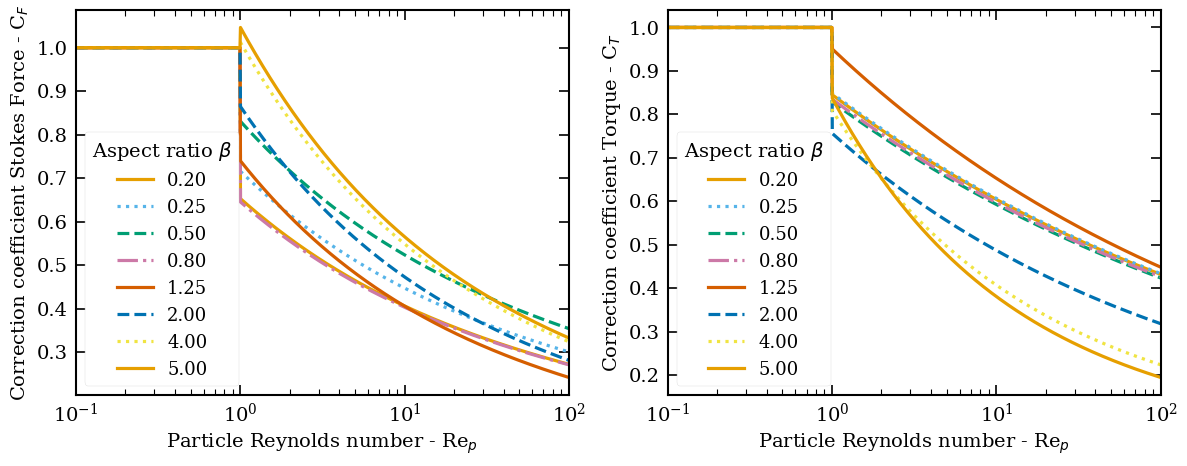

In [52]:
main.plotCoefficientsVsReynoldsNumber()

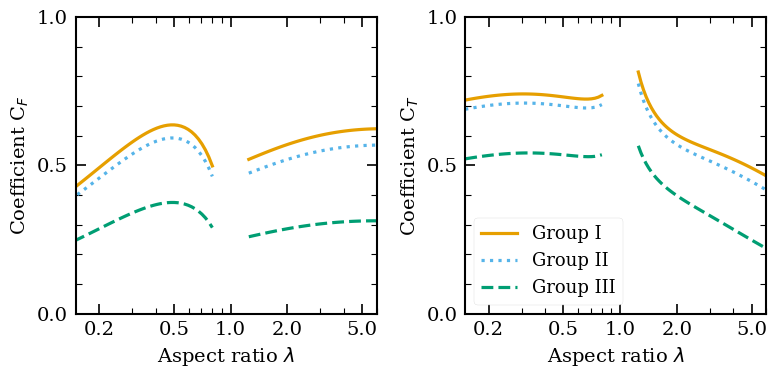

<Figure size 640x440 with 0 Axes>

In [55]:
main.plotCorrectionCoefficients()
plt.savefig("figures/reproduce_coefficents.pdf", bbox_inches="tight")

100%|██████████| 20/20 [01:28<00:00,  4.40s/it]


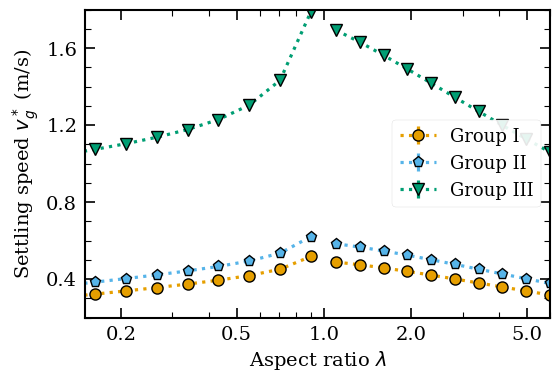

<Figure size 640x440 with 0 Axes>

In [56]:
main.plotSettlingSpeedVsAspectRatio()
plt.savefig("figures/reproduce_settling_speed.pdf", bbox_inches="tight")

# Matlab comparison

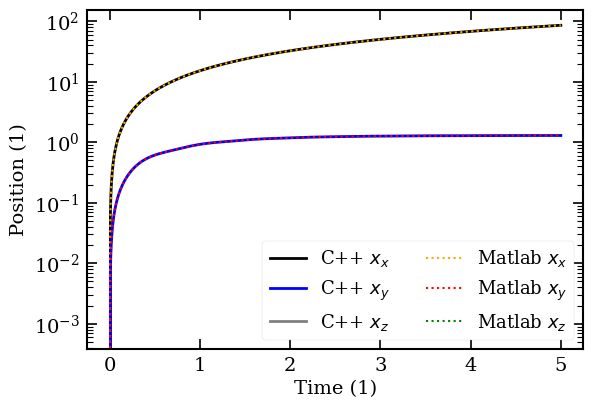

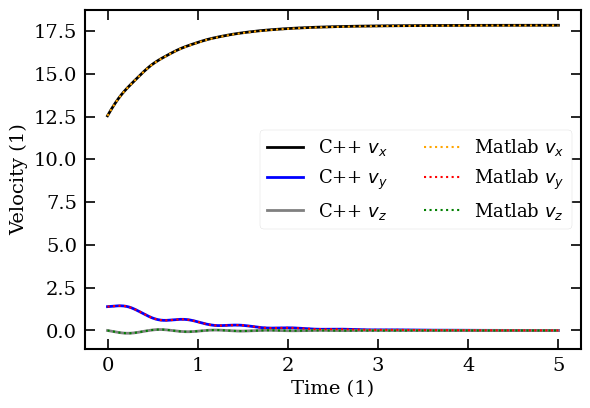

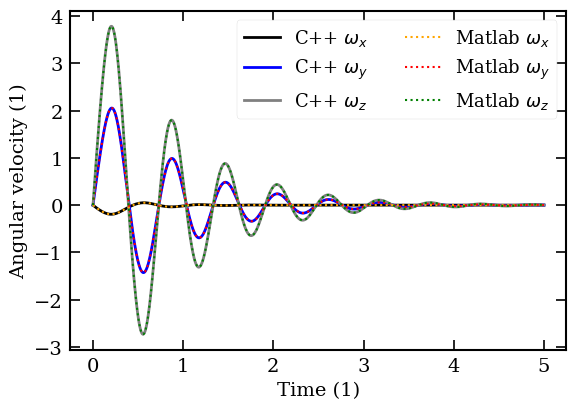

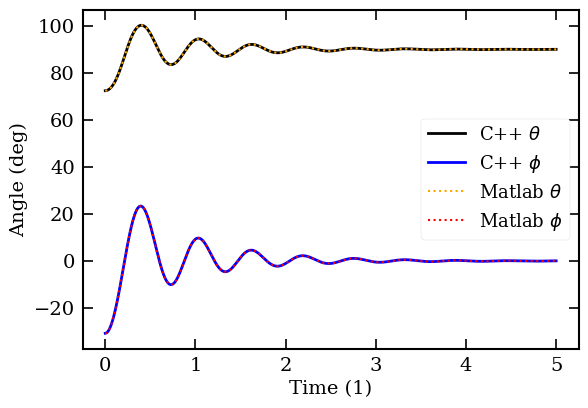

In [ ]:
# TODO: Save angular velocity and velocity
a_parallel=2.4e-05
a_perp=0.00012
g=9.82
nu=1.5115e-05
const = dynamics.SystemConstants(
    gravitational_acceleration=g,
    fluid_kinematic_viscosity=nu,
    a_perp=a_perp,
    a_para=a_parallel,
)

mat_data = np.loadtxt("data/traj_apara2.4e-05_aperp0.00012_lambda0.2_g9.82_nu1.5115e-05_curlyR996_taup0.042174_CF0.49114_CT0.73226.txt")
t_mat = mat_data[:,0]
res_mat = mat_data[:,1:]
initial = res_mat[0]

x0     = initial[0:3] * np.sqrt(const.tau_p * const.nu) / (g * const.tau_p ** 2)
v0     = initial[3:6] * np.sqrt(const.tau_p * const.nu) / (g * const.tau_p ** 2)
n0     = initial[6:9]
omega0 = initial[9:12]
y0 = np.concat([x0, v0, n0, omega0])
t_end = t_mat[-1]
t = np.linspace(0.0, t_end, num=1000)

t_py, res_py = c_dynamics.solveDynamics(
    y0=y0,
    const=const,
    t_eval=t,
    t_span=(0.0, t_end),
    rel_tol=1e-12,
    abs_tol=1e-12,
    event_type=0
)
res_py[:,:3] *= (np.linalg.norm(const.g) * const.tau_p ** 2) / np.sqrt(const.tau_p * const.nu)
res_py[:,3:6] *= (np.linalg.norm(const.g) * const.tau_p ** 2) / np.sqrt(const.tau_p * const.nu)
# plot results
plt.style.use("plot_style.mplstyle")
for offset_idx, name, symbol in zip([0, 3, 9], ["Position", "Velocity", "Angular velocity"], ["x", "v", "\\omega"]):
    plt.figure()
    plt.plot(t_py, res_py[:,offset_idx+0], label=f"C++ ${symbol}_x$", color="black", ls="solid", lw=2)
    plt.plot(t_py, res_py[:,offset_idx+1], label=f"C++ ${symbol}_y$", color="blue", ls="solid", lw=2)
    plt.plot(t_py, res_py[:,offset_idx+2], label=f"C++ ${symbol}_z$", color="grey", ls="solid", lw=2)
    plt.plot(t_mat, res_mat[:,offset_idx+0], label=f"Matlab ${symbol}_x$", ls=":", color="orange", lw=1.5)
    plt.plot(t_mat, res_mat[:,offset_idx+1], label=f"Matlab ${symbol}_y$", ls=":", color="red", lw=1.5)
    plt.plot(t_mat, res_mat[:,offset_idx+2], label=f"Matlab ${symbol}_z$", ls=":", color="green", lw=1.5)
    plt.legend(ncols=2)
    if symbol == "x":
        plt.yscale("log")
    # plt.ylim(-1, 2.0)
    plt.xlabel("Time (1)")
    plt.ylabel(f"{name} (1)")
plt.show()
plt.figure()
plt.plot(t_py, np.arccos(res_py[:,8]) * 180 / np.pi, label="C++ $\\theta$", color="black", ls="solid", lw=2)
plt.plot(t_py, np.sign(res_py[:,7]) * np.arccos(res_py[:,6] / np.sqrt(res_py[:,6] ** 2 + res_py[:,7] ** 2)) * 180 / np.pi, label="C++ $\\phi$", color="blue", ls="solid", lw=2)
plt.plot(t_mat, np.arccos(res_mat[:,8]) * 180 / np.pi, label="Matlab $\\theta$", ls=":", color="orange", lw=1.5)
plt.plot(t_mat, np.sign(res_mat[:,7]) * np.arccos(res_mat[:,6] / np.sqrt(res_mat[:,6] ** 2 + res_mat[:,7] ** 2)) * 180 / np.pi, label="Matlab $\\phi$", ls=":", color="red", lw=1.5)
plt.legend(loc="center right")
plt.xlabel("Time (1)")
plt.ylabel(f"Angle (deg)")
plt.show()

# Analytical bifurcation

In [ ]:
from dynamics import (
    resistanceCoefficient,
    translationalResistanceCoefficients,
    rotationalResistanceCoefficients,
    computeCurlyAStokesForce,
    computeCurlyATorque
)

def hopfBifurcation(beta, curly_R, curly_V):
    A_perp, A_para = translationalResistanceCoefficients(beta)
    C_perp, _ = rotationalResistanceCoefficients(beta)
    A_g = resistanceCoefficient(beta)
    c_config = c_dynamics.CppConfig(dynamics.SystemConstants(a_para=beta, a_perp=1.0))

    Re_p0 = max(1, beta) * curly_R * curly_V / (6 * np.pi * A_g)
    C_F = c_config.correctionFactorStokesForce(Re_p0)
    Re_p = (4 / 3) * max(1, beta) / A_g * (np.sqrt(1 + C_F * curly_R * curly_V / (4 * np.pi)) - 1) / C_F
    C_T = c_config.correctionFactorTorque(Re_p)

    curly_A_F = C_F * computeCurlyAStokesForce(curly_R, curly_V)
    curly_A_T = C_T * computeCurlyATorque(beta, curly_R, curly_V)
    v_g = (np.sqrt(1 + 8 * curly_A_F) - 1) / (4 * A_perp * curly_A_F)

    # (APara CPerp (1 + 3 APara curlyAF vG - APerp curlyAF vG) (5 CPerp +
    #  3 APara^2 curlyAF vG (1 + \[Beta]^2) -
    #  APara (-1 + APerp curlyAF vG) (1 + \[Beta]^2)))/(vG^2 (5 CPerp -
    #  APerp (1 + \[Beta]^2) + 3 APara^2 curlyAF vG (1 + \[Beta]^2) -
    #  2 APerp^2 curlyAF vG (1 + \[Beta]^2) -
    #  APara (-1 + APerp curlyAF vG) (1 + \[Beta]^2)))
    return (
        A_para*C_perp*(1+3*A_para*curly_A_F*v_g-A_perp*curly_A_F*v_g)
        *(5*C_perp+3*A_para**2*curly_A_F*v_g*(1+beta**2)-A_para*(1+beta**2)*(-1+A_perp*curly_A_F*v_g))
    ) / (v_g**2*(
        5*C_perp
        -A_perp*(1+beta**2)
        +3*A_para**2*curly_A_F*v_g*(1+beta**2)
        -2*A_perp**2*curly_A_F*v_g*(1+beta**2)
        -A_para*(1+beta**2)*(-1+A_perp*curly_A_F*v_g)
    )) - curly_A_T

In [ ]:
x = np.logspace(-5, 5, num=1_000)
f_x = np.array([hopfBifurcation(0.2, 500, y) for y in x])

plt.plot(x, f_x)
plt.axhline(0, ls=":", lw=1, color="black")
plt.xscale("log")
# plt.yscale("log")
# plt.yscale("symlog")
plt.ylim(-1,1)

In [ ]:
def findRootCurlyV(beta: float, curly_R: float, guess_curly_V: float) -> float:
    try:
        curly_V = optimize.root_scalar(
            f=lambda x: hopfBifurcation(beta, curly_R, x),
            x0=guess_curly_V,
            maxiter=1000,
            xtol=1e-12,
            method='bisect',
            bracket=[guess_curly_V * 1e-2, guess_curly_V * 1e2]
        ).root
    except ValueError:
        curly_V = np.nan
    return curly_V

In [ ]:
g = 9.81
nu = 1.51147e-5
curly_R = 1.2e3 / 1.204
guess_curly_V = g * 1.44e-3 * 1e-9 / nu ** 2
beta_arr = np.linspace(0.1, 0.8, num=100)
curly_V_arr = np.array([findRootCurlyV(beta, curly_R, guess_curly_V) for beta in beta_arr])
volume_arr = curly_V_arr * nu ** 2 / g
print(volume_arr[-1] * 1e9)
plt.figure(figsize=(5,4))
plt.plot(beta_arr, volume_arr, label="Analytical Bifurcation")
plt.xlabel("Aspect ratio $\\lambda$")
plt.ylabel("Particle volume (m$^3$)")
plt.legend()
plt.show()

In [ ]:
# ------- initial parameters ---------
MAGNITUDE_PERPUBATION = 1e-3
g = 9.81
nu = 1.51147e-5
curly_R = 1.2e3 / 1.204
beta = 0.5
particle_volume = 5e-10#0.1e-12 * 1e-2
# ------- setup ---------
rng = np.random.default_rng(0)
a_perp, a_parallel = dynamics.spheriodDimensionsFromBeta(beta, particle_volume)
const = dynamics.SystemConstants(
    gravitational_acceleration=g,
    fluid_kinematic_viscosity=nu,
    particle_density=1.2e3,
    fluid_density=1.204,
    a_perp=a_perp,
    a_para=a_parallel,
)
c_config = c_dynamics.CppConfig(const)
C_F = c_config.correctionFactorStokesForce(const.Re_p0)
curly_A_F = C_F * const.curly_A_F
v_g_star = (np.sqrt(1 + 8 * curly_A_F) - 1) / (4 * const.A_perp * curly_A_F)
# ------- fixed point ---------
x_fixed = np.array([0.0, 0.0, 0.0]) # NOTE: The value of x does not actually matter
v_fixed = np.array([v_g_star, 0.0, 0.0])
n_fixed = np.array([1.0, 0.0, 0.0])
omega_fixed = np.array([0.0, 0.0, 0.0])
# ------- initial state ---------
x0 = x_fixed.copy()
v0 = v_fixed + MAGNITUDE_PERPUBATION * rng.normal(size=3)
n0 = n_fixed + MAGNITUDE_PERPUBATION * rng.normal(size=3) # NOTE: Needs to be normalized to 1
omega0 = omega_fixed + MAGNITUDE_PERPUBATION * rng.normal(size=3)

n0 = n0 / np.linalg.norm(n0)
y0 = np.concat([x0, v0, n0, omega0])

t = np.linspace(0.0, 200.0, num=1000)

t, res = c_dynamics.solveDynamics(
    y0=y0,
    const=const,
    t_eval=t,
    rel_tol=1e-6,
    abs_tol=1e-6,
    event_type=0
)
omega = res[:,9:]
theta = np.arccos(res[:,8])
phi = np.sign(res[:,7]) * np.arccos(res[:,6] / np.sqrt(res[:,6] ** 2 + res[:,7] ** 2))

In [ ]:
plt.plot(t[100:], omega[100:])
plt.show()

In [ ]:
plt.plot(t, theta)
# plt.plot(t, phi)
plt.show()